In [1]:
# LIBRARIES IMPORT ------------------------------------------------
import pandas as pd
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense, LSTM, TimeDistributed, Input

from matplotlib import pyplot as plt
%matplotlib inline

# function for RMSLE
def rmsle(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

C:\Users\Thomas\HPI\MP\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# DATA DOWNLOAD ========================================================   
# air reservation system
air_reserve = pd.read_csv('data/air_reserve.csv')
air_store_info = pd.read_csv('data/air_store_info.csv')
air_visit_data = pd.read_csv('data/air_visit_data.csv')

# hpg reservation system
hpg_reserve = pd.read_csv('data/hpg_reserve.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')

# additional data
store_id_relation = pd.read_csv('data/store_id_relation.csv')
date_info = pd.read_csv('data/date_info.csv')

# test data
sample_sub = pd.read_csv('data/sample_submission.csv')

In [3]:
# DATA PREPARATION =====================================================
# TEST DATA ------------------------------------------------------------
# transform test data
air_test = sample_sub.copy()
air_test['air_store_id'] = air_test['id'].apply(lambda x: str(x)[:-11])
air_test['visit_date'] = air_test['id'].apply(lambda x: str(x)[-10:])

# dataframe for predictions
submission_lstm = air_test.copy()

# test set for merger with train set
air_test = air_test.drop(['id', 'visitors'], axis = 1)

In [4]:
# DATA ON RESERVATION --------------------------------------------------
# combine air and hpg databases
hpg_air_reserve = store_id_relation.join(hpg_reserve.set_index('hpg_store_id'), on = 'hpg_store_id')
air_reserve_tmp = air_reserve.copy()
hpg_air_reserve = hpg_air_reserve.drop('hpg_store_id', axis = 1)
reserve = pd.concat([air_reserve_tmp, hpg_air_reserve])

# convert columns of "reserve" table into datetime format
reserve['visit_datetime'] =  pd.to_datetime(reserve['visit_datetime'])
reserve['reserve_datetime'] =  pd.to_datetime(reserve['reserve_datetime'])

# create column for visit date inside "reserve" table
reserve['visit_date'] = reserve['visit_datetime'].apply(lambda x: str(x)[0:10])

# calculate the gap between visit time and reservation time inside "reserve" table
reserve['hour_gap'] = reserve['visit_datetime'].sub(reserve['reserve_datetime'])
reserve['hour_gap'] = reserve['hour_gap'].apply(lambda x: x/np.timedelta64(1,'h'))

# separate reservation into 5 categories based on gap lenght
reserve['reserve_-12_h'] = np.where(reserve['hour_gap'] <= 12,
                                    reserve['reserve_visitors'], 0)
reserve['reserve_12_37_h'] = np.where((reserve['hour_gap'] <= 37) & (reserve['hour_gap'] > 12),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_37_59_h'] = np.where((reserve['hour_gap'] <= 59) & (reserve['hour_gap'] > 37),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_59_85_h'] = np.where((reserve['hour_gap'] <= 85) & (reserve['hour_gap'] > 59),
                                       reserve['reserve_visitors'], 0)
reserve['reserve_85+_h'] = np.where((reserve['hour_gap'] > 85),
                                     reserve['reserve_visitors'], 0)

# group by air_store_id and visit_date to enable joining with main table
group_list = ['air_store_id', 'visit_date', 'reserve_visitors', 'reserve_-12_h',
              'reserve_12_37_h', 'reserve_37_59_h', 'reserve_59_85_h', 'reserve_85+_h']
reserve = reserve[group_list].groupby(['air_store_id', 'visit_date'], as_index = False).sum()

for i in group_list[2:]:
    reserve[i] = reserve[i].apply(lambda x: np.log1p(x))

In [5]:
# GENRE DATA ----------------------------------------------------------
# total amount of restaurants of specific genres by area_name
air_genres_area = air_store_info.copy()
air_genres_area = air_genres_area[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_genre_name', 'air_area_name'],
                                                                                              as_index = False).count()
air_genres_area = air_genres_area.rename(columns = {'air_store_id': 'genre_in_area'})

# total amount of restaurants in area
air_area = air_store_info.copy()
air_area = air_area[['air_store_id', 'air_area_name']].groupby(['air_area_name'], as_index = False).count()
air_area = air_area.rename(columns = {'air_store_id': 'total_r_in_area'})

In [6]:
# WEEKEND AND HOLIDAYS ------------------------------------------------
# additional features for weekends and holidays
date_info_mod = date_info.copy()
date_info_mod['holiday_eve'] = np.zeros(date_info_mod.shape[0])
date_info_mod['holiday_eve'].iloc[:-1] = date_info_mod['holiday_flg'].copy().values[1:]
date_info_mod['non_working'] = np.where(date_info_mod['day_of_week'].isin(['Saturday', 'Sunday']) |
                                        date_info_mod['holiday_flg'] == 1, 1, 0)
date_info_mod = date_info_mod.drop('holiday_flg', axis = 1)

# average visitors per restaurant by working and non-working days
air_visit_wd = air_visit_data.join(date_info_mod.set_index('calendar_date'), on = 'visit_date')
air_visit_wd['visitors'] = air_visit_wd['visitors'].apply(lambda x: np.log1p(x)) 

# average visitors per restaurant
mean_df = air_visit_wd[['visitors',
                        'air_store_id',
                        'non_working']].copy().groupby(['air_store_id',
                                                        'non_working'],
                                                        as_index = False).mean()
mean_df = mean_df.rename(columns = {'visitors': 'visitors_mean'})


# median visitors per restaurant
median_df = air_visit_wd[['visitors',
                          'air_store_id',
                          'non_working']].copy().groupby(['air_store_id',
                                                          'non_working'],
                                                          as_index = False).median()
median_df = median_df.rename(columns = {'visitors': 'visitors_median'})

# max visitors per restaurant
max_df = air_visit_wd[['visitors',
                       'air_store_id',
                       'non_working']].copy().groupby(['air_store_id',
                                                       'non_working'],
                                                       as_index = False).max()
max_df = max_df.rename(columns = {'visitors': 'visitors_max'})

# min visitors per restaurant
min_df = air_visit_wd[['visitors',
                       'air_store_id',
                       'non_working']].copy().groupby(['air_store_id',
                                                       'non_working'],
                                                       as_index = False).min()
min_df = min_df.rename(columns = {'visitors': 'visitors_min'})

C:\Users\Thomas\HPI\MP\venv\lib\site-packages\pandas-0.22.0-py3.5-win-amd64.egg\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# JOIN TABLES INTO TRAINING AND TEST SETS ----------------------------
# function for combining train/test dataset with additional information
def merge_join(df):
    # add month of visit
    df['month'] = df['visit_date'].apply(lambda x: float(str(x)[5:7]))

    # add weekday and holiday flag
    df = df.join(date_info_mod.set_index('calendar_date'), on = 'visit_date')


    # add genre and area name)
    df = df.join(air_store_info.set_index('air_store_id'), on = 'air_store_id')

    # add quantity of same genre in area
    df = pd.merge(df, air_genres_area, how = 'left',
                  left_on = ['air_genre_name', 'air_area_name'],
                  right_on = ['air_genre_name', 'air_area_name'])


    # add total quatity of restaurants in area
    df = pd.merge(df, air_area, how = 'left',
                  left_on = ['air_area_name'],
                  right_on = ['air_area_name'])

    # add reservation information
    df = pd.merge(df, reserve, how = 'left',
                  left_on = ['air_store_id', 'visit_date'],
                  right_on = ['air_store_id', 'visit_date'])

    # add visitors number mean, median, max and min per each restaurant
    df = pd.merge(df, mean_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])

    df = pd.merge(df, median_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])
    
    df = pd.merge(df, max_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])
    
    df = pd.merge(df, min_df, how = 'left',
                  left_on = ['air_store_id', 'non_working'],
                  right_on = ['air_store_id', 'non_working'])
    
    # change NaN to 0
    df = df.fillna(0) 
   
    return df

# combine train/test data with additional information
air_train = air_visit_data.copy()
X = merge_join(air_train)
X_test = merge_join(air_test)

In [8]:
# stores = X.groupby(['air_store_id']).sum()
# 391 days, from 2016-01-13 to 2017-04-22
one_store = X[X['air_store_id'] == 'air_03963426c9312048']

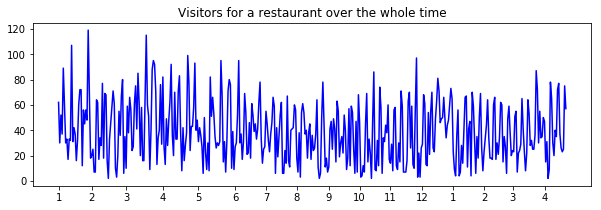

In [9]:
plt.figure(figsize=(10, 3))
plt.plot(one_store['visitors'], color='blue')
# plt.plot(one_store['month'], color='gray')
# Set ticks for each first day of a month
first_days = one_store[one_store['month'] != one_store['month'].shift()]
plt.xticks(first_days.index, first_days['month'].astype(int))
plt.title('Visitors for a restaurant over the whole time')
# Visitors>60 -> often friday
# hist = plt.hist(one_store[one_store['visitors'] > 60]['day_of_week'])
None

In [10]:
# ENCODE STRING FEATURES ----------------------------------------------
# (one-hot encoding may provide better result,
# I preferred to apply labels encoding to avoid high dimensional feature space)

# https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# IMPROVEMENT: Use One-Hot-Encoding (orthogonal dimensions) and PCA (avoiding curse of dimensionality)

# Weekday
le_weekday = preprocessing.LabelEncoder()
le_weekday.fit(X['day_of_week'])
X['day_of_week'] = le_weekday.transform(X['day_of_week'])
X_test['day_of_week'] = le_weekday.transform(X_test['day_of_week'])

# Genre name
le_genre = preprocessing.LabelEncoder()
le_genre.fit(X['air_genre_name'])
X['air_genre_name'] = le_genre.transform(X['air_genre_name'])
X_test['air_genre_name'] = le_genre.transform(X_test['air_genre_name'])

# Area name
le_area = preprocessing.LabelEncoder()
le_area.fit(X['air_area_name'])
X['air_area_name'] = le_area.transform(X['air_area_name'])
X_test['air_area_name'] = le_area.transform(X_test['air_area_name'])

# id
le_id = preprocessing.LabelEncoder()
le_id.fit(X['air_store_id'])
X['air_store_id'] = le_id.transform(X['air_store_id'])
X_test['air_store_id'] = le_id.transform(X_test['air_store_id'])

In [ ]:
# SIMULTANEOUS TRANSFORMATION OF TRAIN AND TEST SETS -------------------
# combine train and test sets
X_all = X.append(X_test)

# date table (includes all dates for training and test period)
dates = np.arange(np.datetime64(X_all.visit_date.min()),
                  np.datetime64(X_all.visit_date.max()) + 1,
                  datetime.timedelta(days=1))
ids = X_all['air_store_id'].unique()
dates_all = dates.tolist()*len(ids)
ids_all = np.repeat(ids, len(dates.tolist())).tolist()
df_all = pd.DataFrame({"air_store_id": ids_all, "visit_date": dates_all})
df_all['visit_date'] = df_all['visit_date'].copy().apply(lambda x: str(x)[:10])

# create copy of X_all with data relevant to 'visit_date'
X_dates = X_all[['visit_date', 'month', 'day_of_week', 'holiday_eve', 'non_working']].copy()

# remove duplicates to avoid memory issues
X_dates = X_dates.drop_duplicates('visit_date')

# merge dataframe that represents all dates per each restaurant with information about each date
df_to_reshape = df_all.merge(X_dates,
                             how = "left",
                             left_on = 'visit_date',
                             right_on = 'visit_date')

# create copy of X_all with data relevant to 'air_store_id'
X_stores = X_all[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude',
                  'longitude', 'genre_in_area', 'total_r_in_area']].copy()       

# remove duplicates to avoid memory issues
X_stores = X_stores.drop_duplicates('air_store_id')

# merge dataframe that represents all dates per each restaurant with information about each restaurant
df_to_reshape = df_to_reshape.merge(X_stores,
                                    how = "left",
                                    left_on = 'air_store_id',
                                    right_on = 'air_store_id')

# merge dataframe that represents all dates per each restaurant with inf. about each restaurant per specific date
df_to_reshape = df_to_reshape.merge(X_all[['air_store_id', 'visit_date', 'reserve_visitors', 'visitors_mean', 
                                       'visitors_median', 'visitors_max', 'visitors_min', 'visitors']],
                                    how = "left",
                                    left_on = ['air_store_id', 'visit_date'],
                                    right_on = ['air_store_id', 'visit_date'])

# separate 'visitors' into output array
Y_lstm_df = df_to_reshape[['visit_date', 'air_store_id', 'visitors']].copy().fillna(0)

# take log(y+1)
Y_lstm_df['visitors'] = np.log1p(Y_lstm_df['visitors'].values)

# add flag for days when a restaurant was closed
df_to_reshape['closed_flag'] = np.where(df_to_reshape['visitors'].isnull() &
                                        df_to_reshape['visit_date'].isin(X['visit_date']).values,1,0)

# drop 'visitors' and from dataset
df_to_reshape = df_to_reshape.drop(['visitors'], axis = 1)

# fill in NaN values
df_to_reshape = df_to_reshape.fillna(-1)

# list of df_to_reshape columns without 'air_store_id' and 'visit_date'
columns_list = [x for x in list(df_to_reshape.iloc[:,2:])]

# bound all numerical values between -1 and 1
# note: to avoid data leakage 'fit' should be made on traid data and 'transform' on train and test data
# in this case all data in test set is taken from train set, thus fit/transform on all data 
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_to_reshape[columns_list])
df_to_reshape[columns_list] = scaler.transform(df_to_reshape[columns_list])

In [ ]:
# SPECIFIC PREPARATION FOR NEURAL NETWORK AND ENCODER/DECODER ---------------
# reshape X into (samples, timesteps, features)
X_all_lstm = df_to_reshape.values[:,2:].reshape(len(ids),
                                                len(dates),
                                                df_to_reshape.shape[1]-2)

# isolate output for train set and reshape it for time series
Y_lstm_df = Y_lstm_df.loc[Y_lstm_df['visit_date'].isin(X['visit_date'].values) &
                          Y_lstm_df['air_store_id'].isin(X['air_store_id'].values),]
Y_lstm = Y_lstm_df.values[:,2].reshape(len(X['air_store_id'].unique()),
                                       len(X['visit_date'].unique()),
                                       1)

# test dates
n_test_dates = len(X_test['visit_date'].unique())

# make additional features for number of visitors in t-1, t-2, ... t-7
t_minus = np.ones([Y_lstm.shape[0],Y_lstm.shape[1],1])
for i in range(1,8):
    temp = Y_lstm.copy()
    temp[:,i:,:] = Y_lstm[:,0:-i,:].copy()
    t_minus = np.concatenate((t_minus[...], temp[...]), axis = 2)
t_minus = t_minus[:,:,1:]


# split X_all into training and test data
X_lstm = X_all_lstm[:,:-n_test_dates,:]
X_lstm_test = X_all_lstm[:,-n_test_dates:,:]

# add t-1, t-2 ... t-7 visitors to feature vector
X_lstm = np.concatenate((X_lstm[...], t_minus[...]), axis = 2)

# split training set into train and validation sets
X_tr = X_lstm[:,39:-140,:]
Y_tr = Y_lstm[:,39:-140,:]

X_val = X_lstm[:,-140:,:]
Y_val = Y_lstm[:,-140:,:]

In [ ]:
# ENCODER-DECODER MODEL ===================================================
# many thanks to the following resources:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# https://blog.keras.io/building-autoencoders-in-keras.html
# http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf
# https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/
# https://github.com/Arturus/kaggle-web-traffic

# MODEL FOR ENCODER AND DECODER -------------------------------------------
num_encoder_tokens = X_lstm.shape[2]
latent_dim = 64 # to avoid "kernel run out of time" situation. I used 256.

# encoder training
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder = LSTM(latent_dim, 
               batch_input_shape = (1, None, num_encoder_tokens),
               stateful = False,
               return_sequences = True,
               return_state = True,
               recurrent_initializer = 'glorot_uniform')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c] # 'encoder_outputs' are ignored and only states are kept.

# Decoder training, using 'encoder_states' as initial state.
decoder_inputs = Input(shape=(None, num_encoder_tokens))

decoder_lstm_1 = LSTM(latent_dim,
                      batch_input_shape = (1, None, num_encoder_tokens),
                      stateful = False,
                      return_sequences = True,
                      return_state = False,
                      dropout = 0.2,
                      recurrent_dropout = 0.2) # True

decoder_lstm_2 = LSTM(32, # to avoid "kernel run out of time" situation. I used 128.
                     stateful = False,
                     return_sequences = True,
                     return_state = True,
                     dropout = 0.2,
                     recurrent_dropout = 0.2)

decoder_outputs, _, _ = decoder_lstm_2(decoder_lstm_1(decoder_inputs, initial_state = encoder_states))
decoder_dense = TimeDistributed(Dense(Y_lstm.shape[2], activation = 'relu'))
decoder_outputs = decoder_dense(decoder_outputs)

# training model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
training_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# useful for understanding the model architecture
# training_model.summary()

In [ ]:
# GENERATOR APPLIED TO FEED ENCODER AND DECODER ---------------------------
# generator that randomly creates times series of 39 consecutive days
# theses time series has following 3d shape: 829 restaurants * 39 days * num_features 
def dec_enc_n_days_gen(X_3d, Y_3d, length):
    while 1:
        decoder_boundary = X_3d.shape[1] - length - 1
        
        encoder_start = np.random.randint(0, decoder_boundary)
        encoder_end = encoder_start + length
        
        decoder_start = encoder_start + 1
        decoder_end = encoder_end + 1
        
        X_to_conc = X_3d[:, encoder_start:encoder_end, :]
        Y_to_conc = Y_3d[:, encoder_start:encoder_end, :]
        X_to_decode = X_3d[:, decoder_start:decoder_end, :]
        Y_decoder = Y_3d[:, decoder_start:decoder_end, :]
        
        yield([X_to_conc,
               X_to_decode],
               Y_decoder)

In [ ]:
# TRAINING -------------------------------------------------------------
# Training on X_tr/Y_tr and validate with X_val/Y_val
# To perform validation training on validation data should be
# made instead of training on full data set.
# Then validation check is made on period outside of training data
# (included in code below).
'''
training_model.fit_generator(dec_enc_n_days_gen(X_tr, Y_tr, 39),
                             validation_data = dec_enc_n_days_gen(X_val, Y_val, 39),
                             steps_per_epoch = X_lstm.shape[0],
                             validation_steps = X_val.shape[0],
                             verbose = 1,
                             epochs = 1)
'''

# Training on full dataset
history = training_model.fit_generator(dec_enc_n_days_gen(X_lstm[:,:,:], Y_lstm[:,:,:], 39),
                            steps_per_epoch = X_lstm[:,:,:].shape[0],
                            verbose = 1,
                            epochs = 1)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# PREDICTION FUNCTION --------------------------------------------------

# function takes 39 days before first prediction day (input_seq)
# then using encoder to identify hidden states for these 39 days.
# Next, decoder takes hidden states provided by encoder
# and predicts number of visitors from day 2 to day 40.
# Day 40 is the first day of target_seq.

# Predicted value for day 40 is appended to features of day 41.
# Then function takes period from day 2 to day 40 and repeat the process
# unil all days in target sequence get their predictions. 

# The output of the function is the vector with predictions that has
# following shape: 820 restaurants * 39 days * 1 predicted visitors amount

def predict_sequence(inf_enc, inf_dec, input_seq, Y_input_seq, target_seq):
    # state of input sequence produced by encoder
    state = inf_enc.predict(input_seq)
    
    # restrict target sequence to the same shape as X_lstm_test
    target_seq = target_seq[:,:, :X_lstm_test.shape[2]]
    
    # create vector that contains y for previous 7 days
    t_minus_seq = np.concatenate((Y_input_seq[:,-1:,:], input_seq[:,-1:, X_lstm_test.shape[2]:-1]), axis = 2)
    
    # current sequence that is going to be modified each iteration of the prediction loop
    current_seq = input_seq.copy()
    
    
    # predicting outputs
    output = np.ones([target_seq.shape[0],1,1])
    for i in range(target_seq.shape[1]):
        # add visitors for previous 7 days into features of a new day
        new_day_features = np.concatenate((target_seq[:,i:i+1,:], t_minus_seq[...]), axis = 2)
        
        # move prediction window one day forward
        current_seq = np.concatenate((current_seq[:,1:,:], new_day_features[:,]), axis = 1)
        
        
        # predict visitors amount
        pred = inf_dec.predict([current_seq] + state)
        
        # update t_minus_seq
        t_minus_seq = np.concatenate((pred[:,-1:,:], t_minus_seq[...]), axis = 2)
        t_minus_seq = t_minus_seq[:,:,:-1]        
        
        # update predicitons list
        output = np.concatenate((output[...], pred[:,-1:,:]), axis = 1)
        
        # update state
        state = inf_enc.predict(current_seq)
    
    return output[:,1:,:]

In [ ]:
# INFERENCE ENCODER AND DECODER -----------------------------------------    
# inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

# inference decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs,_,_ = decoder_lstm_2(decoder_lstm_1(decoder_inputs,
                                                    initial_state = decoder_states_inputs))
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs])

In [ ]:
# VALIDATION ON PERIOD OUTSIDE OF TRAINING DATA -----------------------
# should be used for validation after "training_model" was trained on X_tr
'''
val_list = []

for i in range(5):
    
    start = np.random.randint(0, int(X_val.shape[1]-X_lstm_test.shape[1]*2))
    end = start+39
    dec_start = end
    dec_end = dec_start+39

    predictions = predict_sequence(encoder_model,
                                   decoder_model,
                                   X_val[:,start:end,:],
                                   Y_val[:,start:end,:],
                                   X_val[:,dec_start:dec_end,:])
    score = rmsle(Y_val[:,dec_start:dec_end,:].reshape(X_val[:,start:end,:].shape[0]*39), 
                  predictions.reshape(X_val[:,start:end,:].shape[0]*39))
    val_list.append(score)

print (np.asarray(val_list).mean())
print (np.asarray(val_list).std())
'''

# Predicting test values
enc_dec_pred = predict_sequence(encoder_model,
                                decoder_model,
                                X_lstm[:,-X_lstm_test.shape[1]:,:],
                                Y_lstm[:,-X_lstm_test.shape[1]:,:],
                                X_lstm_test[:,:,:])

# Add predicted test values to submission dataset ---------------------

# Note: it is important to preserve the order of time series.
# Thus, test set will contain all 829 lines in the same order as train set.
# To make this 'air_store_id' is taken as in X and not in X_test (second line of 'test' variable below).
# Only relevant results will be merged for submission dataframe
test = df_to_reshape.loc[df_to_reshape['visit_date'].isin(X_test['visit_date'].values) &
                         df_to_reshape['air_store_id'].isin(X['air_store_id'].values),]


# reshape predicted values to initial shape
test_pred = enc_dec_pred.reshape(test.shape[0], 1)
test_pred_exp = np.exp(test_pred) - 1.0
test_pred_exp[test_pred_exp<0] = 0

# add predictions to dataframe with 'air_store_id' and 'visit_date'
test_df_pred = test[['air_store_id', 'visit_date']].copy()
test_df_pred['predicted'] = test_pred_exp

# reverse transform of 'air_store_id'
test_df_pred['air_store_id'] = le_id.inverse_transform(test_df_pred['air_store_id'])

# finalizing submission csv file
submission_df = submission_lstm.merge(test_df_pred,
                                     how = 'left',
                                     left_on = ['air_store_id', 'visit_date'],
                                     right_on = ['air_store_id', 'visit_date'])

submission_df['visitors'] = submission_df['predicted']
submission_df = submission_df.drop(['air_store_id', 'visit_date', 'predicted'], axis = 1)
submission_df.to_csv('submission.csv', index = False)